<a href="https://colab.research.google.com/github/AnnegretH/test-repository/blob/master/heart.csv_%20ANN_Feature_Columns__and_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import tensorflow as tf
from tensorflow import keras
from tensorboard.plugins.hparams import api as hp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorboard.plugins.hparams import api as hp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import os
data = pd.read_csv('heart.csv')
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

Text(0.5, 1.0, 'Age vs Maximum Heart Rate Scatter Plot')

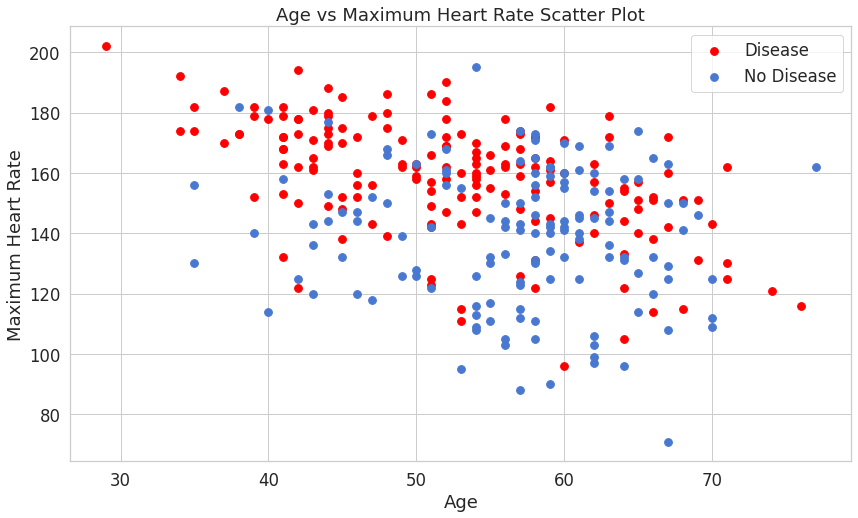

In [0]:
#How disease presence is affected by thalach (“Maximum Heart Rate”) vs age:
plt.scatter(x=data.age[data.target==1], y=data.thalach[(data.target==1)], c="red", s=60)
plt.scatter(x=data.age[data.target==0], y=data.thalach[(data.target==0)], s=60)
plt.legend(["Disease", "No Disease"])
plt.xlabel("Age")
plt.ylabel("Maximum Heart Rate");
plt.title('Age vs Maximum Heart Rate Scatter Plot')
#Looks like maximum heart rate can be very predictive for the presence of a disease, regardless of age.

In [0]:
data.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [0]:
data.describe

<bound method NDFrame.describe of      age  sex  cp  trestbps  chol  fbs  ...  exang  oldpeak  slope  ca  thal  target
0     63    1   3       145   233    1  ...      0      2.3      0   0     1       1
1     37    1   2       130   250    0  ...      0      3.5      0   0     2       1
2     41    0   1       130   204    0  ...      0      1.4      2   0     2       1
3     56    1   1       120   236    0  ...      0      0.8      2   0     2       1
4     57    0   0       120   354    0  ...      1      0.6      2   0     2       1
..   ...  ...  ..       ...   ...  ...  ...    ...      ...    ...  ..   ...     ...
298   57    0   0       140   241    0  ...      1      0.2      1   0     3       0
299   45    1   3       110   264    0  ...      0      1.2      1   0     3       0
300   68    1   0       144   193    1  ...      0      3.4      1   2     3       0
301   57    1   0       130   131    0  ...      1      1.2      1   1     3       0
302   57    0   1       130   2

In [0]:
data.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib as plt
from matplotlib import rc

from sklearn.model_selection import train_test_split
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
import matplotlib as plt 
import matplotlib.pyplot as plt 

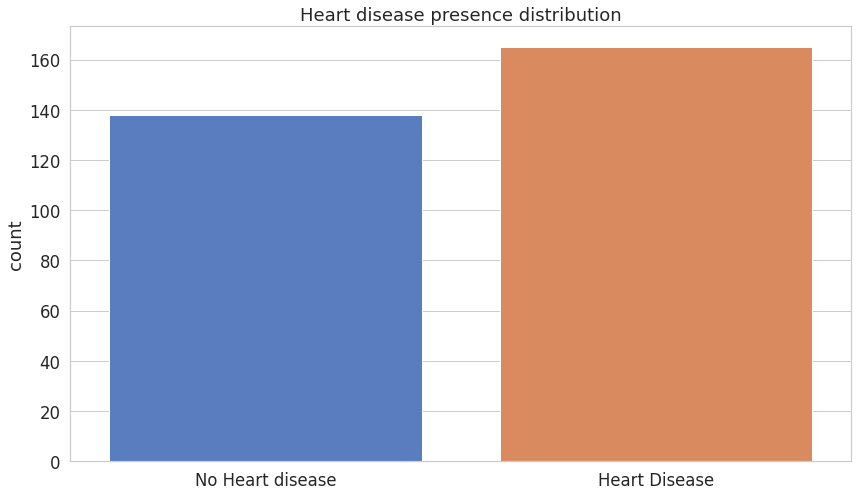

In [0]:
import seaborn as sns
f = sns.countplot(x='target', data=data)
f.set_title("Heart disease presence distribution")
f.set_xticklabels(['No Heart disease', 'Heart Disease'])
plt.xlabel("");

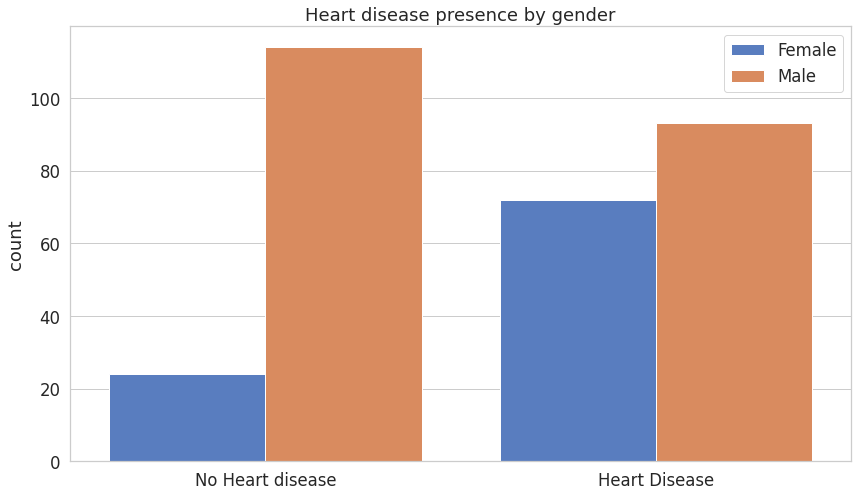

In [0]:
f = sns.countplot(x='target', data=data, hue='sex')
plt.legend(['Female', 'Male'])
f.set_title("Heart disease presence by gender")
f.set_xticklabels(['No Heart disease', 'Heart Disease'])
plt.xlabel("");

Text(0.5, 1.0, 'Age Distribution of Non Heart Diseased Patients')

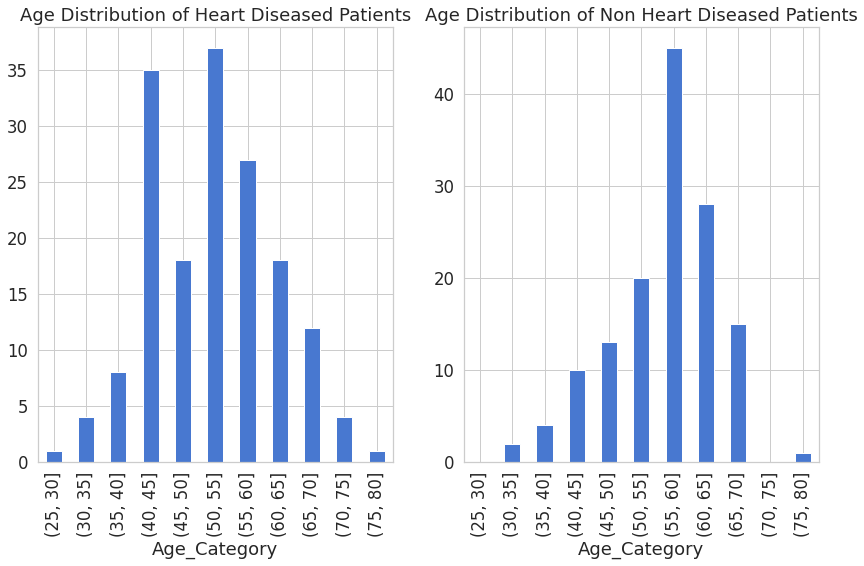

In [0]:
data['Age_Category'] = pd.cut(data['age'],bins=list(np.arange(25, 85, 5)))
plt.subplot(121)
data[data['target']==1].groupby('Age_Category')['age'].count().plot(kind='bar')
plt.title('Age Distribution of Heart Diseased Patients')
plt.subplot(122)
data[data['target']==0].groupby('Age_Category')['age'].count().plot(kind='bar')
plt.title('Age Distribution of Non Heart Diseased Patients')

In [0]:
del data['Age_Category']


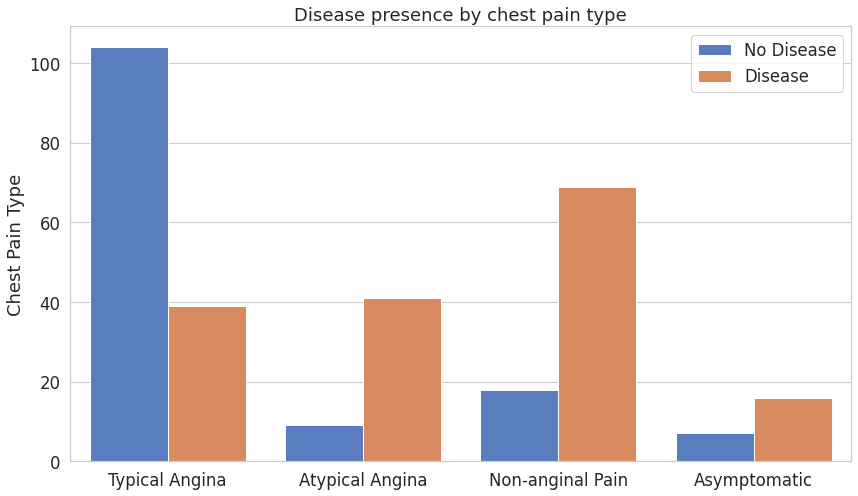

In [0]:
f = sns.countplot(x='cp', data=data, hue='target')
f.set_xticklabels(['Typical Angina', 'Atypical Angina', 'Non-anginal Pain', 'Asymptomatic']);
f.set_title('Disease by chest pain type')
plt.ylabel('Chest Pain Type')
plt.xlabel('')
plt.legend(['No Disease', 'Disease']);

In [0]:
X = data.loc[:,data.columns!='target']
y = data.iloc[:,-1]
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [0]:
feature_columns = []

# numeric columns
for header in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']:
  feature_columns.append(tf.feature_column.numeric_column(header))

# bucketized columns
age = tf.feature_column.numeric_column("age")
age_buckets = tf.feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
feature_columns.append(age_buckets)

# indicator columns
data["thal"] = data["thal"].apply(str)
thal = tf.feature_column.categorical_column_with_vocabulary_list(
      'thal', ['3', '6', '7'])
thal_one_hot = tf.feature_column.indicator_column(thal)
feature_columns.append(thal_one_hot)

data["sex"] = data["sex"].apply(str)
sex = tf.feature_column.categorical_column_with_vocabulary_list(
      'sex', ['0', '1'])
sex_one_hot = tf.feature_column.indicator_column(sex)
feature_columns.append(sex_one_hot)

data["cp"] = data["cp"].apply(str)
cp = tf.feature_column.categorical_column_with_vocabulary_list(
      'cp', ['0', '1', '2', '3'])
cp_one_hot = tf.feature_column.indicator_column(cp)
feature_columns.append(cp_one_hot)

data["slope"] = data["slope"].apply(str)
slope = tf.feature_column.categorical_column_with_vocabulary_list(
      'slope', ['0', '1', '2'])
slope_one_hot = tf.feature_column.indicator_column(slope)
feature_columns.append(slope_one_hot)


# embedding columns
thal_embedding = tf.feature_column.embedding_column(thal, dimension=8)
feature_columns.append(thal_embedding)

# crossed columns _ feature crossing
age_thal_crossed = tf.feature_column.crossed_column([age_buckets, thal], hash_bucket_size=1000)
age_thal_crossed = tf.feature_column.indicator_column(age_thal_crossed)
feature_columns.append(age_thal_crossed)

cp_slope_crossed = tf.feature_column.crossed_column([cp, slope], hash_bucket_size=1000)
cp_slope_crossed = tf.feature_column.indicator_column(cp_slope_crossed)
feature_columns.append(cp_slope_crossed)

In [0]:
def create_dataset(dataframe, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  return tf.data.Dataset.from_tensor_slices((dict(dataframe), labels)) \
          .shuffle(buffer_size=len(dataframe)) \
          .batch(batch_size)

In [0]:
train, test = train_test_split(data, test_size=0.3, random_state=RANDOM_SEED)

In [0]:
train_ds = create_dataset(train)
test_ds = create_dataset(test)

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.DenseFeatures(feature_columns=feature_columns),
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, validation_data=test_ds, epochs=100, use_multiprocessing=True)

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

7/7 [==============================] - 0s 65ms/step - loss: 2.2505 - accuracy: 0.5660 - val_loss: 1.1929 - val_accuracy: 0.5604
Epoch 2/100
7/7 [==============================] - 0s 7ms/step - loss: 1.4028 - accuracy: 0.4811 - val_loss: 0.5705 - val_accuracy: 0.7363
Epoch 3/100
7/7 [==============================] - 0s 6ms/step - loss: 1.0020 - accuracy: 0.5613 - val_loss: 0.6152 - val_accuracy: 0.6154
Epoch 4/100
7/7 [==============================] - 0s 6ms/step - loss: 0.9938 - accuracy: 

In [0]:
model.evaluate(test_ds)

3/3 [==============================] - 0s 3ms/step - loss: 0.4424 - accuracy: 0.8022


[0.44242772459983826, 0.8021978139877319]

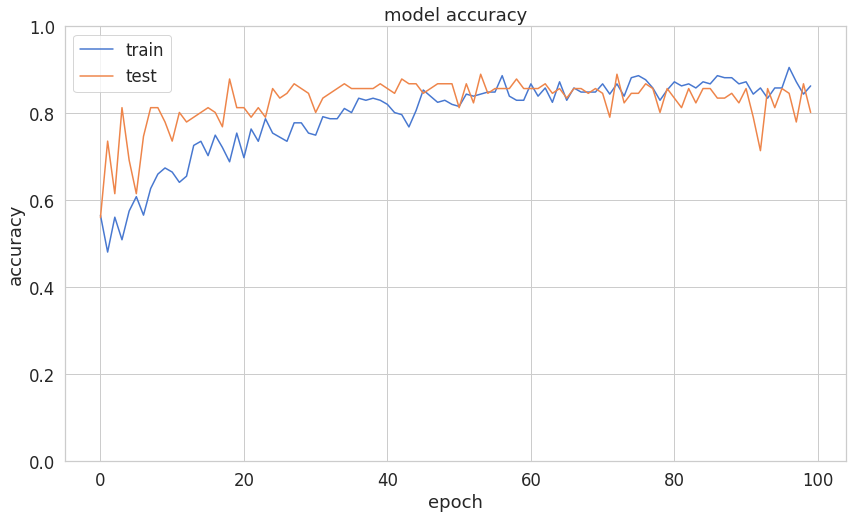

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0, 1))
plt.legend(['train', 'test'], loc='upper left');

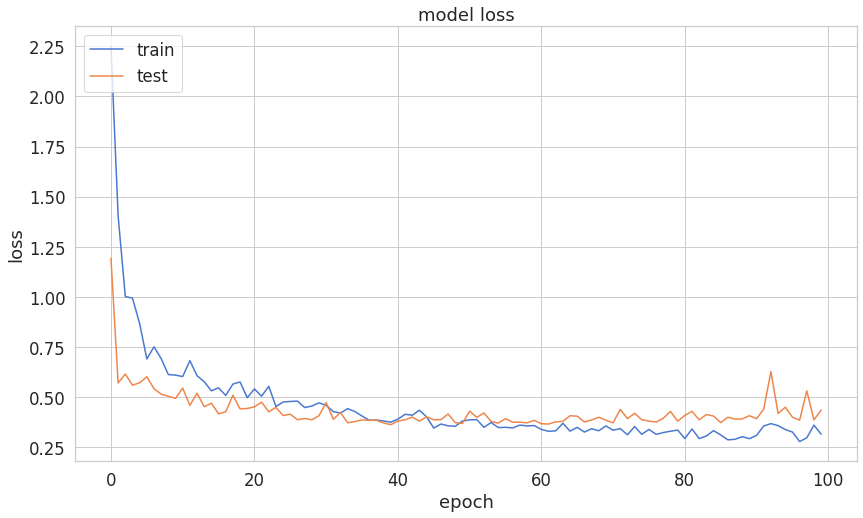

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
predictions = model.predict(test_ds)

In [0]:
bin_predictions = tf.round(predictions).numpy().flatten()

In [0]:
print(classification_report(y_test.values, bin_predictions))

NameError: ignored

Text(0.5, 1.0, 'Variable Heat Map')

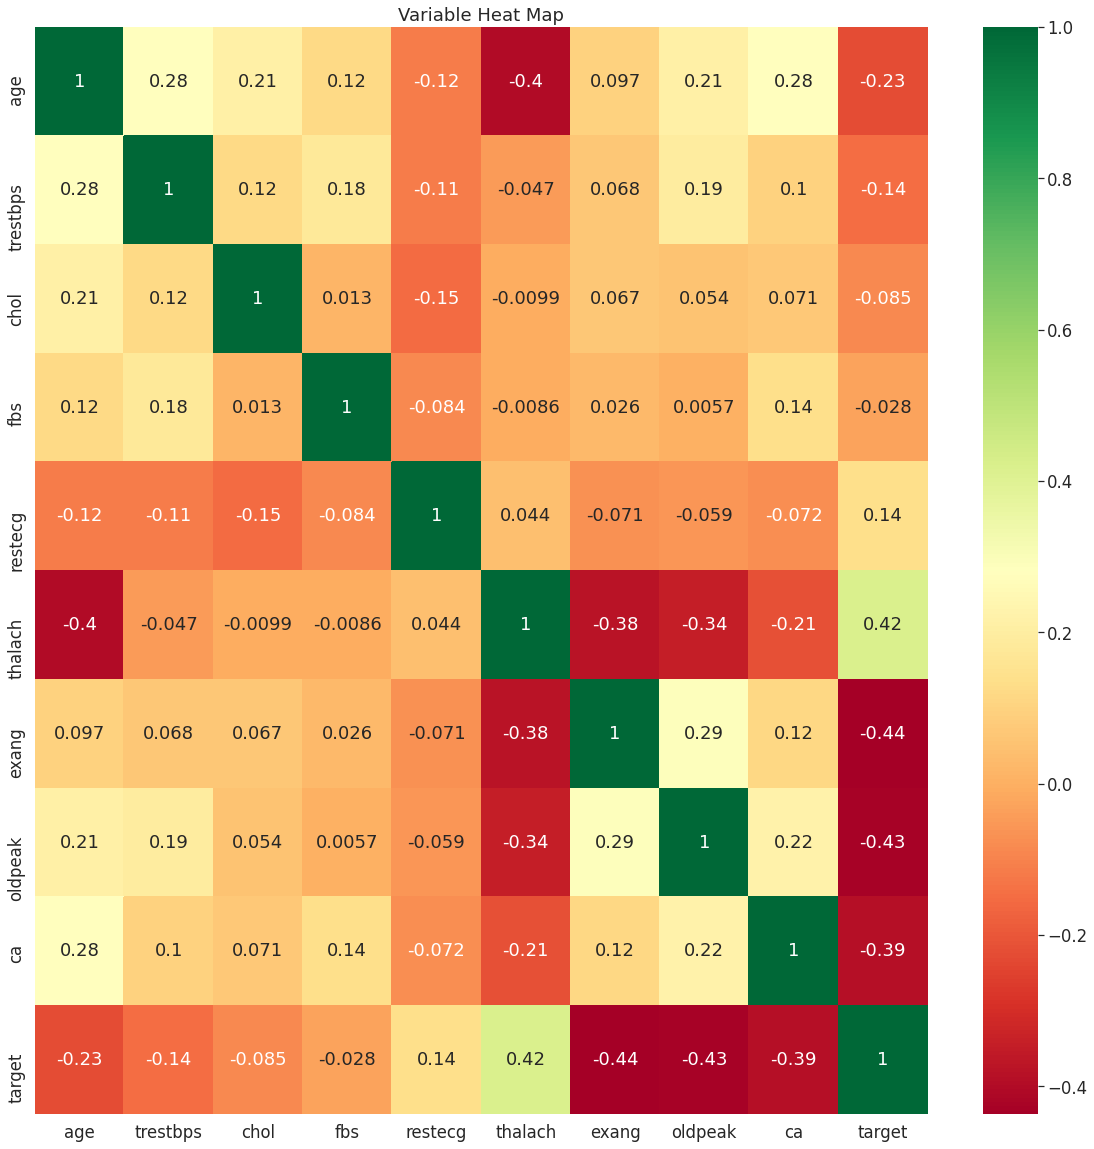

In [0]:
#HeatMap ! :) feature selection the positive correlations like chest pain, shows that there is a significant correlation
#between [chestpain, thalach, slope] and heart disease.  I did the heat mat for all the data, not the tain data. 
import seaborn as sns
#get correlations
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot the heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")
plt.title('Variable Heat Map')

In [0]:
data.hist()
#this shows us histograms of the data. again this is for all teh data not the training data

In [0]:
sns.set_style('whitegrid')
sns.countplot(x='target',data=data,palette='RdBu_r')
#this tells us whether our dataset is balanced or not... it is quite balanced

In [0]:
#our data exploration tells us that we need to convert some of the categorical variables into dummy variables, and then scale all the values before we train the models with machine learning.  
#We first used the get_dummies method to make dummy columns for categorical variables.  See category pic.
dataset = pd.get_dummies(data, columns = ['sex', 'cp', 'fbs', 'restecg', 'restecg', 'exang', 'slope', 'ca', 'thal']) 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
columns_to_scale = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
dataset[columns_to_scale] = standardScaler.fit_transform(dataset[columns_to_scale])

In [0]:
#we did some standard scaling because there are some features that have many variations,
# and which are measured in inconsistent units.
# Some sort of standard scaling should always be used when features are measured using different units. 
# this allows us to scale down our value down to standard normal distribution
# we don't do it on the category features, we apply it to the remaining categories. 
#also note, not to do it on the target feature as that will already be zero. 

In [0]:
dataset.head()

In [0]:
#now I'm going to split my data into training data and test data
#first, I return a random, shuffled sample of data
data1=data.sample(frac=1).reset_index(drop=True)
#to randomly assign t/f valeues to 
split=0.7
msk = np.random.rand(len(data)) < split
train_labels = data.loc[msk, data.columns =='Target']
train_data  = data.loc[msk, data.columns !='Target']

test_labels = data.loc[~msk, data.columns =='Target']
test_data  = data.loc[~msk, data.columns !='Target']

print(test_data.head(1))
print(test_labels.head(1))
print(train_data.head(1))
print(train_labels)

print(test_data.shape[0]+train_data.shape[0])



In [0]:
#normalize the data,  set y axis to 0

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data = (train_data - mean) / std
test_data = (test_data - mean) / std


In [0]:
test_data


In [0]:
train_data
#I got rid of dummy data
#see the dummy datas? these are the _0,_1,_2,_3_, you
#can also see how age, trestbps and chol (ones which we normalized) are not part of dummy data. You
#can also see how those values have been re-scaled down based on the standard normal distribution. 

In [0]:
#not deap network with activation function, but additional insights for report: using knearest neighbor and cross validation:
#for Knearest Neighbor, for train_data_x will be my independent feature, y will be my dependent feature
y = dataset['target']
x = dataset.drop(['target'], axis = 1)
from sklearn.model_selection import cross_val_score


knn_scores = []
for k in range (1,21):
  knn_classifier = KNeighborsClassifier(n_neighbors = k)
  score=cross_val_score(knn_classifier,x,y,cv=10)
  knn_scores.append(score.mean())
  

In [0]:

data.shape
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(14, activation=tf.nn.relu,
                       input_shape=(train_data.shape[1],)),
    keras.layers.Dense(14, activation=tf.nn.sigmoid),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])
    
  model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])
  return model
  
 
 

In [0]:
model = build_model()
model.summary()  

In [0]:
#number of neurons in the first layer (input layer), the discrete function is used to define discrete values for the number of units
HP_NUM_UNITS1 = hp.HParam('num_units 1', hp.Discrete([4, 8, 16])) 

#number of neurons in the second layer
HP_NUM_UNITS2 = hp.HParam('num_units 2', hp.Discrete([4, 8]))

#different optimizer to see which one gives better accuracy
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

#our goal is to find the values for the above paramters that gives the best accuracy on the test data
METRIC_ACCURACY = 'accuracy'

In [0]:
with tf.summary.create_file_writer('hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS1,HP_NUM_UNITS2, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )


In [0]:
plt.plot([k for k in range(1, 21)], knn_scores, color = 'blue')
for i in range(1,21):
    plt.text(i, knn_scores[i-1], (i, knn_scores[i-1]))
plt.xticks([i for i in range(1, 21)])
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Scores')
plt.title('K Neighbors Classifier scores for different K values')
#this is for cross val.  not the test data. 
#ke

In [0]:
knn_scores

In [0]:

#it looks like the best accuracy was at k=10
knn_classifier = KNeighborsClassifier(n_neighbors = 10)
score=cross_val_score(knn_classifier,x,y,cv=10)
score.mean ()
#for knn  , k=10 the accuracy was 83.5%

In [0]:
  
tensorboard--logdir=.hparam_tuning